In [24]:
from datetime import datetime
from pprint import pprint
import numpy as np
import pandas as pd

from one.api import ONE
from brainbox.io.one import SessionLoader, EphysSessionLoader
from iblatlas.atlas import AllenAtlas

In [2]:
mode = 'local'  # sets mode for all queries (one.seach* methods)
one = ONE(mode=mode)

In [3]:
# Get administration time in seconds
df_infos = pd.read_csv('recordings.csv')
df_infos['date'] = df_infos['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y').date())
df_infos['administration_time'] = df_infos['administration_time'].apply(lambda x: np.sum(np.array([int(val) for val in x.split(':')]) * np.array([3600, 60, 1])))


In [4]:
# Note: NotImplementedError: Searching on insertions required remote connection
pids_spikes = one.search_insertions(project='psychedelics', dataset='spikes', query_type='remote')

print(f'Psychedelics probes with spike sorting: {len(pids_spikes)}')


Psychedelics probes with spike sorting: 48


In [5]:
# Get overall timings for stimulation protocols
one.mode = 'remote'
eid , probeID= one.pid2eid(pids_spikes[0])

# Asserting that there were two tasks run throughout the sesison - CHECK THIS WORKS
protocols = one.get_details(eid)['task_protocol'].split('/')
assert len(protocols) == 2
assert len(np.unique(protocols)) == 1

pprint(one.list_datasets(eid))
# ALFObjectNotFound: trials 
# loader = SessionLoader(eid=eid, one=one)
# loader.load_trials()

['_ibl_experiment.description.yaml',
 'alf/_ibl_bodyCamera.dlc.pqt',
 'alf/_ibl_bodyCamera.times.npy',
 'alf/_ibl_leftCamera.dlc.pqt',
 'alf/_ibl_leftCamera.times.npy',
 'alf/_ibl_rightCamera.dlc.pqt',
 'alf/_ibl_rightCamera.times.npy',
 'alf/bodyCamera.ROIMotionEnergy.npy',
 'alf/bodyROIMotionEnergy.position.npy',
 'alf/leftCamera.ROIMotionEnergy.npy',
 'alf/leftROIMotionEnergy.position.npy',
 'alf/probe00/electrodeSites.brainLocationIds_ccf_2017.npy',
 'alf/probe00/electrodeSites.localCoordinates.npy',
 'alf/probe00/electrodeSites.mlapdv.npy',
 'alf/probe00/pykilosort/_ibl_log.info_pykilosort.log',
 'alf/probe00/pykilosort/_kilosort_whitening.matrix.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.channels.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.spikes.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.waveforms.npy',
 'alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy',
 'alf/probe00/pykilosort/channels.localCoordinates.npy',
 'alf/probe00/pykilosort/channels.m

In [6]:
['alf/task_00/_ibl_passiveGabor.table.csv',
'alf/task_00/_ibl_passivePeriods.intervalsTable.csv',
'alf/task_00/_ibl_passiveRFM.times.npy',
'alf/task_00/_ibl_passiveStims.table.csv']

first = one.load_dataset(eid, 'alf/task_00/_ibl_passivePeriods.intervalsTable.csv')
second = one.load_dataset(eid, 'alf/task_01/_ibl_passivePeriods.intervalsTable.csv')

print(first)
print(second)

  Unnamed: 0  passiveProtocol  spontaneousActivity         RFM   taskReplay
0      start        40.189634            52.456301  364.755134   678.087198
1       stop      3029.724119           352.488467  665.820531  3029.724119
  Unnamed: 0  passiveProtocol  spontaneousActivity          RFM   taskReplay
0      start      3038.170606          3050.437273  3362.753138  3676.101400
1       stop      4042.941732          3350.486471  3663.834733  4042.941732


In [7]:
# TO-DO To make it more foolproof, confirm order of columns is always the same
# rfms = one.load_dataset(eid, 'alf/task_00/_ibl_passiveRFM.times.npy')
timings = {}
for tid in [0 ,1]:
    eid_info = one.get_details(eid)
    subject = eid_info['subject']
    date = eid_info['date']
    intervals = one.load_dataset(eid, f'alf/task_0{tid}/_ibl_passivePeriods.intervalsTable.csv').set_index('Unnamed: 0')
    spontaneous_start = intervals.loc['start', 'spontaneousActivity']
    spontaneous_stop = intervals.loc['stop', 'spontaneousActivity']
    timings[f'spontaneous_start_0{tid}'] = spontaneous_start
    timings[f'spontaneous_stop_0{tid}'] = spontaneous_stop
    gabors = one.load_dataset(eid, f'alf/task_0{tid}/_ibl_passiveGabor.table.csv')
    stims = one.load_dataset(eid, f'alf/task_0{tid}/_ibl_passiveStims.table.csv')
    task_stop = np.max([gabors['stop'].max(), stims.max().max()])
    timings[f'task_stop_0{tid}'] = task_stop
    admin_time = df_infos[(df_infos['animal_ID'] == subject) & (df_infos['date'] == date)]['administration_time'].values[0]
    timings['admin_time'] = admin_time
print (timings)


#Get spike times for these intervals

{'spontaneous_start_00': 52.45630068464166, 'spontaneous_stop_00': 352.48846745576327, 'task_stop_00': 1002.943728931003, 'admin_time': 1047, 'spontaneous_start_01': 3050.43727260764, 'spontaneous_stop_01': 3350.4864710087613, 'task_stop_01': 3999.650061664}


In [8]:
from brainbox.io.one import SpikeSortingLoader

ba = AllenAtlas(res_um=10)

from brainbox.processing import bincount2D
import seaborn as sns

import matplotlib.pyplot as plt

from os.path import join

from pathlib import Path
from psychedelic_functions import paths

path_dict = paths()

In [9]:
# Load in spikes
sl = SpikeSortingLoader(pid=pids_spikes[0], one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Only keep IBL good neurons
spikes.times = spikes.times[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
spikes.depths = spikes.depths[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
spikes.clusters = spikes.clusters[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]

# Convert to mm
spikes.depths = spikes.depths / 1000

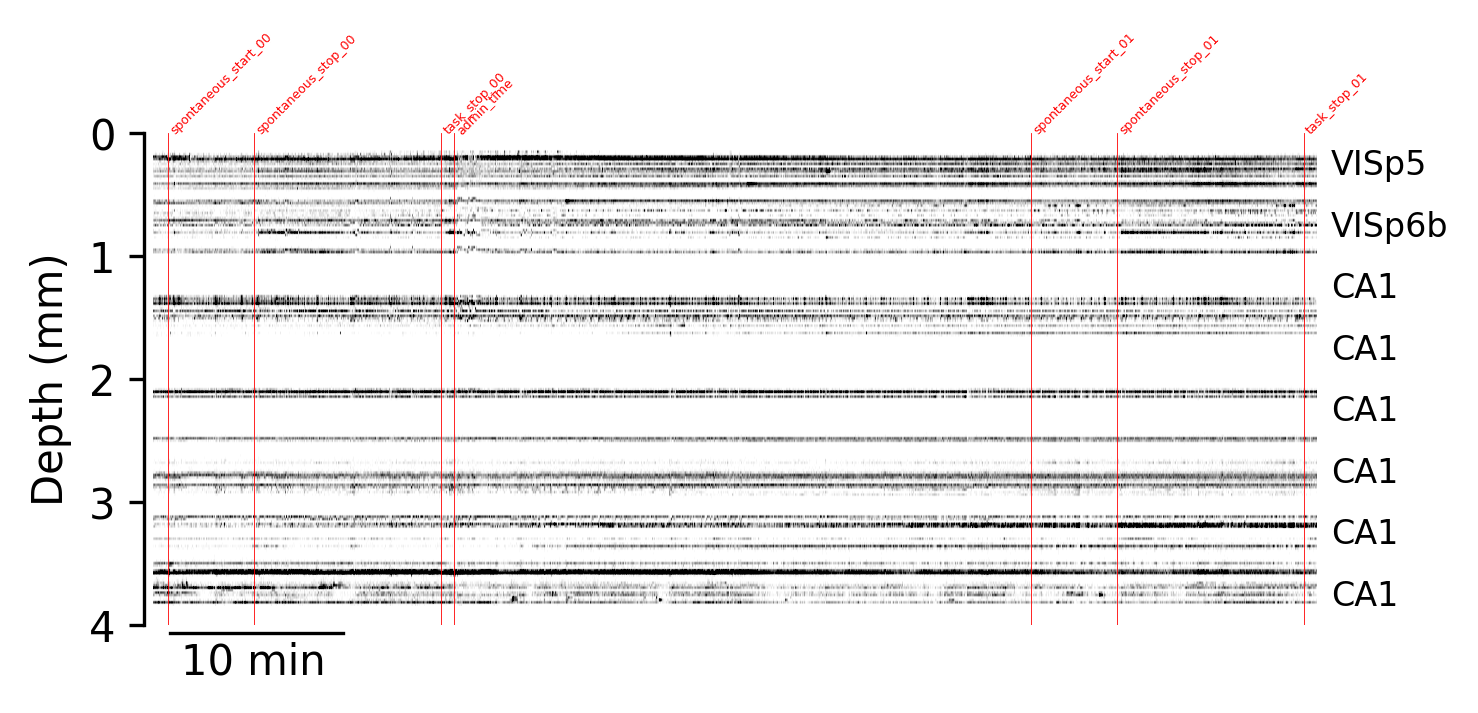

In [10]:
# Get spike raster
iok = ~np.isnan(spikes.depths)
R, times, depths = bincount2D(spikes.times[iok], spikes.depths[iok], xbin=0.01, ybin=0.02, weights=None)
    
# %% Plot figure
f, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
ax1.imshow(R, aspect='auto', cmap='binary', vmin=0, vmax=np.std(R),
           extent=np.r_[times[[0, -1]], depths[[0, -1]]], origin='upper')
ax1.set(ylim=[0, 4], ylabel='Depth (mm)')
#ax1.set_title('Awake', color=colors['awake'], fontweight='bold')
ax1.set(xticks=[ax1.get_xlim()[0] + 60, ax1.get_xlim()[0] + 660])
ax1.text(ax1.get_xlim()[0] + 350, 4.3, '10 min', ha='center', va='center')
ax1.axes.get_xaxis().set_visible(False)
ax1.invert_yaxis()

for i in np.arange(1, channels['acronym'].shape[0], 50):
    ax1.text(ax1.get_xlim()[-1]+50, channels['axial_um'][channels['acronym'].shape[0] - i] / 1000,
             channels['acronym'][i], fontsize=8)
for key in timings:
    ax1.axvline(timings[key], color = "red", linewidth=0.2) # add linewidth parameter to make lines thinner
    ax1.text(timings[key], ax1.get_ylim()[0]-4, key, ha ='left', rotation = 45 ,color = "red", fontsize = 3) # adjust position and rotation of text
plt.tight_layout()
sns.despine(trim=True, offset=2)
plt.savefig(join(path_dict['fig_path'], 'example_raster.pdf'))

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

start_index_00 = find_nearest(times, timings['spontaneous_start_00'])
stop_index_00 = find_nearest(times, timings['spontaneous_stop_00'])
start_index_01 = find_nearest(times, timings['spontaneous_start_01'])
stop_index_01 = find_nearest(times, timings['spontaneous_stop_01'])

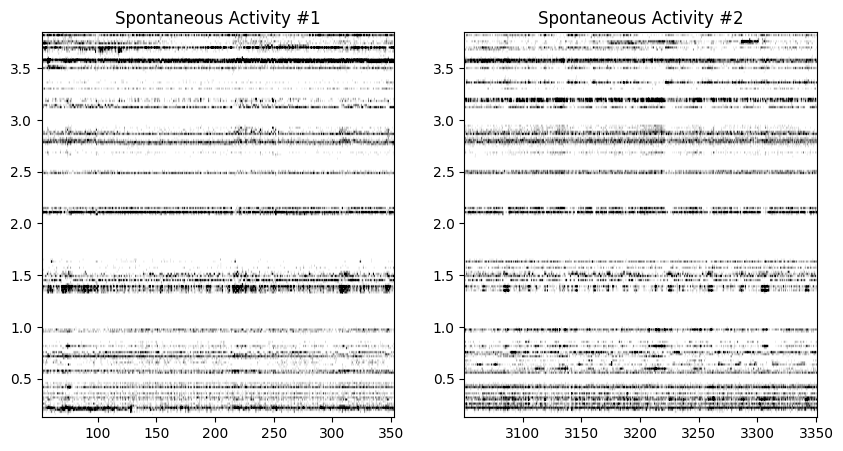

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

spontaneous_activity_00 = R[:, start_index_00:stop_index_00]
spontaneous_activity_01 = R[:, start_index_01:stop_index_01]

im1 = ax1.imshow(spontaneous_activity_00, 
            aspect='auto', cmap='binary', vmin=0, vmax=np.std(R), 
            extent=np.r_[times[[start_index_00, stop_index_00-1]], depths[[0, -1]]], origin='upper')
ax1.set_title('Spontaneous Activity #1')

im2 = ax2.imshow(spontaneous_activity_01, 
            aspect='auto', cmap='binary', vmin=0, vmax=np.std(R), 
            extent=np.r_[times[[start_index_01, stop_index_01-1]], depths[[0, -1]]], origin='upper')
ax2.set_title('Spontaneous Activity #2')

# display the plot
plt.show()

<Figure size 1600x800 with 0 Axes>

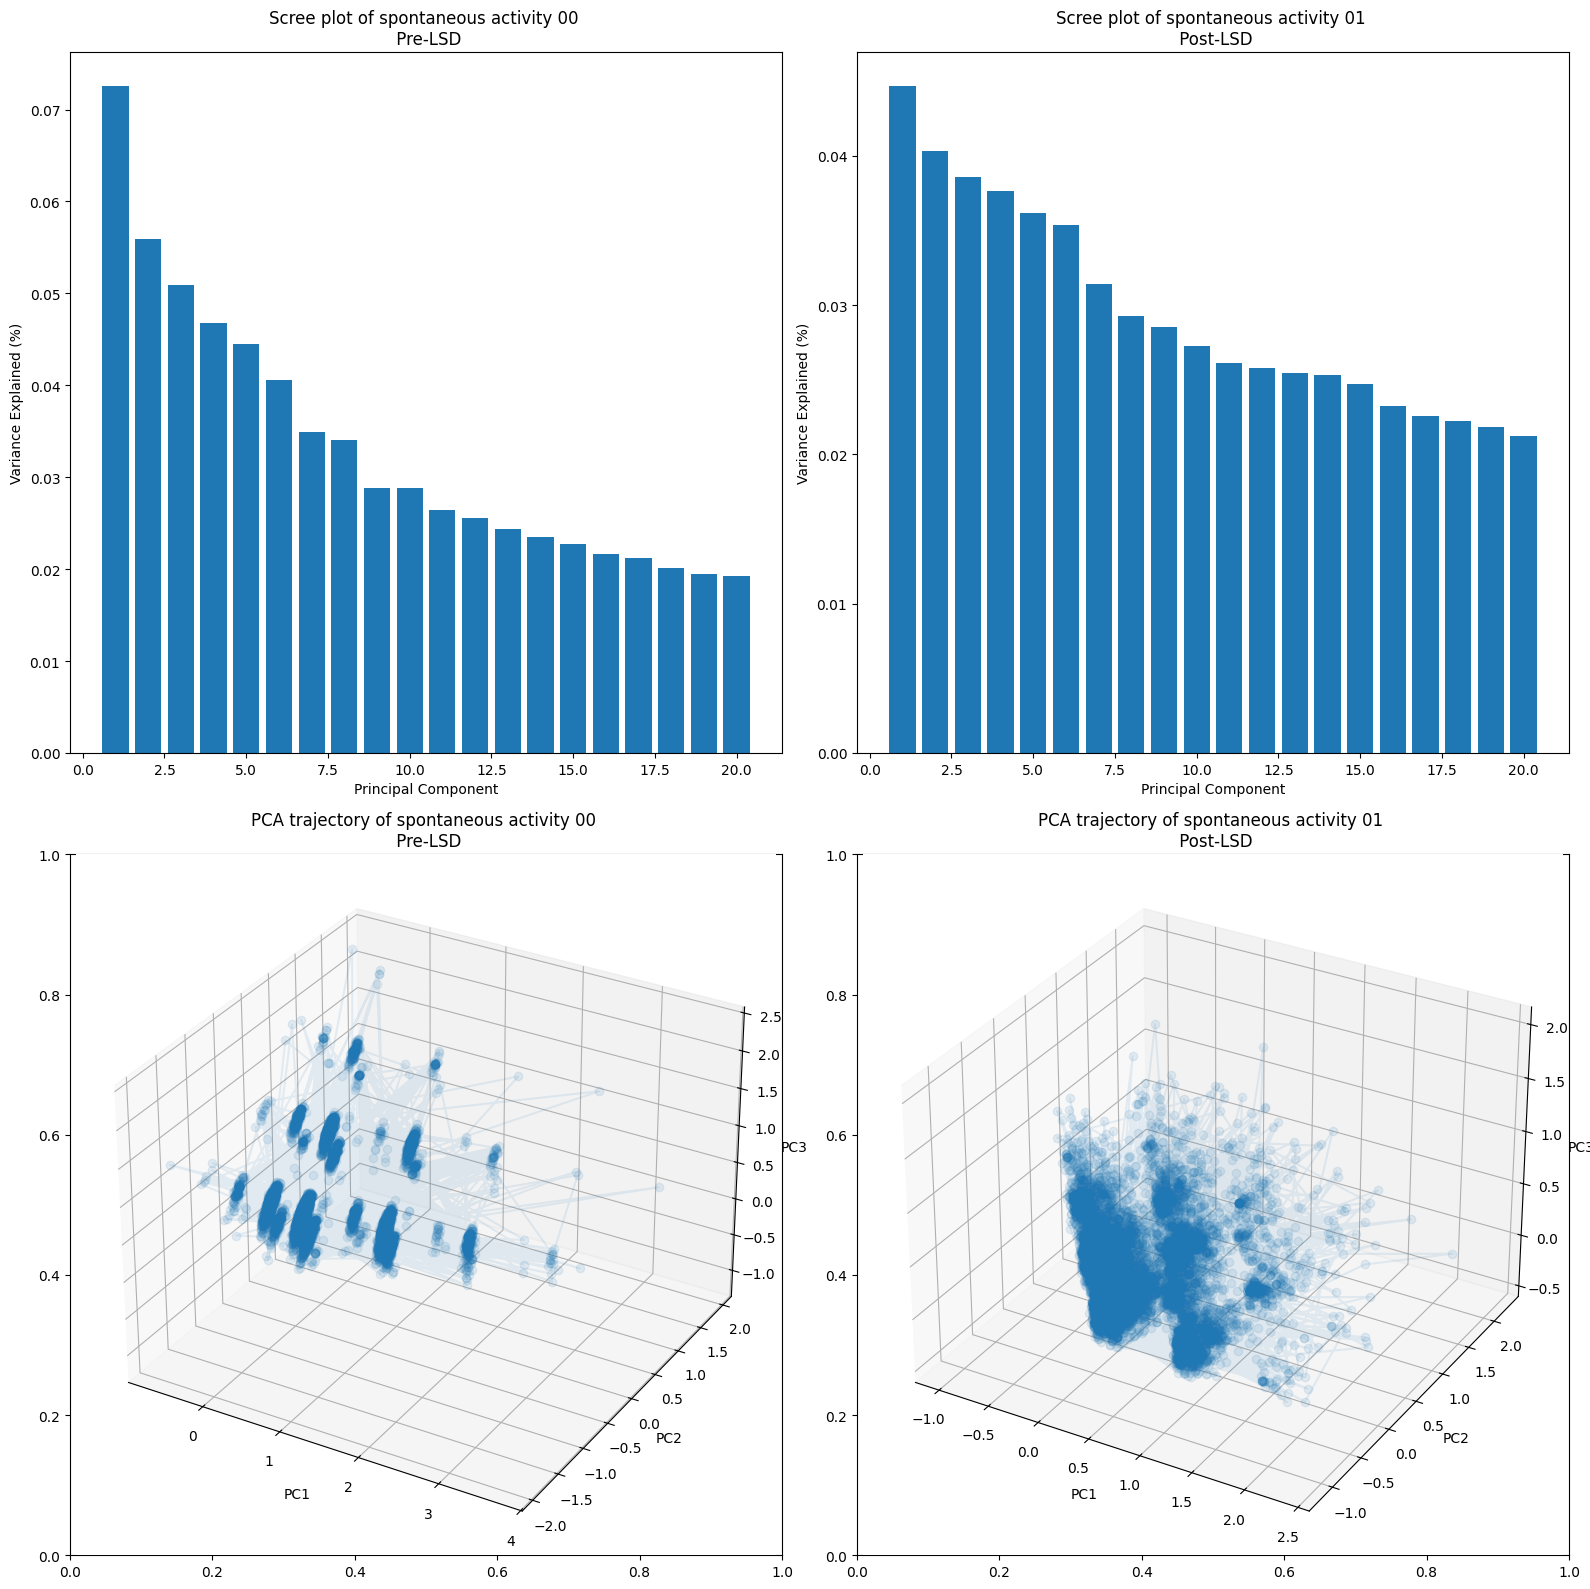

In [23]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# perform PCA to get the first three components
pca = PCA(n_components=20)
pca_result_00 = pca.fit_transform(spontaneous_activity_00.T)  # transpose to make timestamp as row
explained_variance_00 = pca.explained_variance_ratio_ # save the explained variance for 00

pca_result_01 = pca.fit_transform(spontaneous_activity_01.T)  # transpose to make timestamp as row
explained_variance_01 = pca.explained_variance_ratio_ # save the explained variance for 01

fig = plt.figure(figsize = (16,8))


# Create a 2x2 subplot grid
fig, ax = plt.subplots(2, 2, figsize=(16,16))

# create the first 3D subplot
ax1 = fig.add_subplot(2, 2, 3, projection='3d')
ax1.plot(pca_result_00[:,0], pca_result_00[:,1], pca_result_00[:,2], marker = 'o', alpha= 0.1)
ax1.set_title('PCA trajectory of spontaneous activity 00 \n Pre-LSD')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# create the second 3D subplot
ax2 = fig.add_subplot(2, 2, 4, projection='3d')
ax2.plot(pca_result_01[:,0], pca_result_01[:,1], pca_result_01[:,2], marker = 'o', alpha= 0.1)
ax2.set_title('PCA trajectory of spontaneous activity 01 \n Post-LSD')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

# Create the first scree plot
ax[0, 0].bar(np.arange(1,len(explained_variance_00)+1), explained_variance_00)
ax[0, 0].set_title('Scree plot of spontaneous activity 00 \n Pre-LSD')
ax[0, 0].set_xlabel('Principal Component')
ax[0, 0].set_ylabel('Variance Explained (%)')

# Create the second scree plot 
ax[0, 1].bar(np.arange(1,len(explained_variance_01)+1), explained_variance_01)
ax[0, 1].set_title('Scree plot of spontaneous activity 01 \n Post-LSD')
ax[0, 1].set_xlabel('Principal Component')
ax[0, 1].set_ylabel('Variance Explained (%)')

plt.tight_layout()
plt.show()

In [84]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# perform PCA to get the first three components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(spontaneous_activity_00.T)  # transpose to make timestamp as row

# create a colormap, using the number of timestamps
colors = plt.cm.jet(np.linspace(0,1,spontaneous_activity_00.shape[1]))

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection = '3d')

# plot each point separately such that the color can change in time.
for i in range(spontaneous_activity_00.shape[1]): #loop over timestamps
    ax.plot(pca_result[i:i+2, 0], pca_result[i:i+2, 1], pca_result[i:i+2, 2], color=colors[i], alpha = 0.5)
    ax.scatter(pca_result[i, 0], pca_result[i, 1], pca_result[i, 2], color=colors[i], alpha = 0.5, s=10)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()

KeyboardInterrupt: 

In [86]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import numpy as np


# Perform PCA to get the 1st 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(spontaneous_activity_00.T)

# Generate colors
cNorm  = mcolors.Normalize(vmin=0, vmax=spontaneous_activity_00.shape[1]-1)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=plt.cm.jet)

# Make matplotlib's LineCollection
lines = [np.column_stack([pca_result[i,:], pca_result[i+1,:]]).T for i in range(pca_result.shape[0]-1)]
lc = LineCollection(lines, linewidths=1, alpha=0.5, norm=cNorm, cmap=plt.cm.jet)

# Plot each point 
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection = '3d')
ax.add_collection(lc)

ax.set_xlim(pca_result[:,0].min(),pca_result[:,0].max())
ax.set_ylim(pca_result[:,1].min(),pca_result[:,1].max())
ax.set_zlim(pca_result[:,2].min(),pca_result[:,2].max())

# Set PCA projections as coordinates to color according to the time
lc.set_array(np.arange(spontaneous_activity_00.shape[1]-1))

plt.show()

ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (2, 3)

KeyboardInterrupt: 

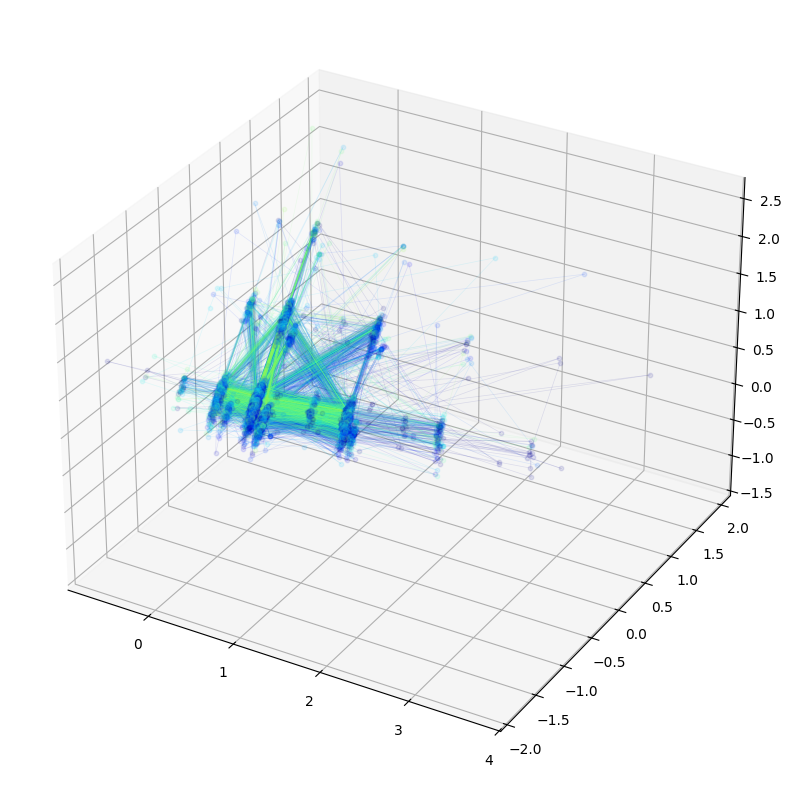

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Perform PCA to get the 1st 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(spontaneous_activity_00.T)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Time as color map
colors = plt.cm.jet(np.linspace(0,1,pca_result.shape[0]))

# Plot each point. Color maps time
for i in range(pca_result.shape[0]):
    ax.plot(pca_result[i:i+2,0],
            pca_result[i:i+2,1],
            pca_result[i:i+2,2],
            color=colors[i],
            alpha=0.1,     # Transparency
            lw=0.5)        # Line width
    ax.scatter(pca_result[i,0],
               pca_result[i,1],
               pca_result[i,2],
               color=colors[i],
               alpha=0.1,
               s=10)         # Size 

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()